# Set up

In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import tensorflow as tf

2024-03-24 12:47:34.663247: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Basic RNNs

First, we need to download the ridership data. It originally comes from Chicago's Transit Authority, and was downloaded from the [Chicago's Data Portal]().

In [2]:
tf.keras.utils.get_file(
    "ridership.tgz",
    "https://github.com/ageron/data/raw/main/ridership.tgz",
    cache_dir=".",
    extract=True,
)

'./datasets/ridership.tgz'

In [3]:
path = Path("datasets/ridership/CTA_-_Ridership_-_Daily_Boarding_Totals.csv")
df = pd.read_csv(path, parse_dates=["service_date"])
df.columns = ["date", "day_type", "bus", "rail", "total"]  # shorter names
df = df.sort_values("date").set_index("date")
df = df.drop("total", axis=1)  # no need to total, it's just bus + rail
df = df.drop_duplicates()  # remove duplicate months (2011-10 and 2017-07)

In [4]:
df.head()

,day_type,bus,rail
date,,,
2001-01-01,U,297192,126455
2001-01-02,W,780827,501952
2001-01-03,W,824923,536432
2001-01-04,W,870021,550011
2001-01-05,W,890426,557917


Let's look at the first few months of 2019 (note that Pandas treats the range boundaries inclusively).

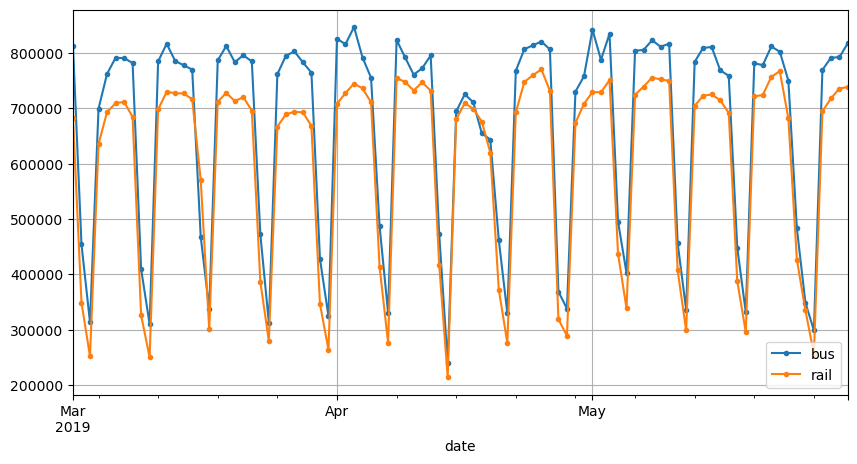

In [5]:
df["2019-03":"2019-05"].plot(grid=True, marker=".", figsize=(10, 5))
plt.show()

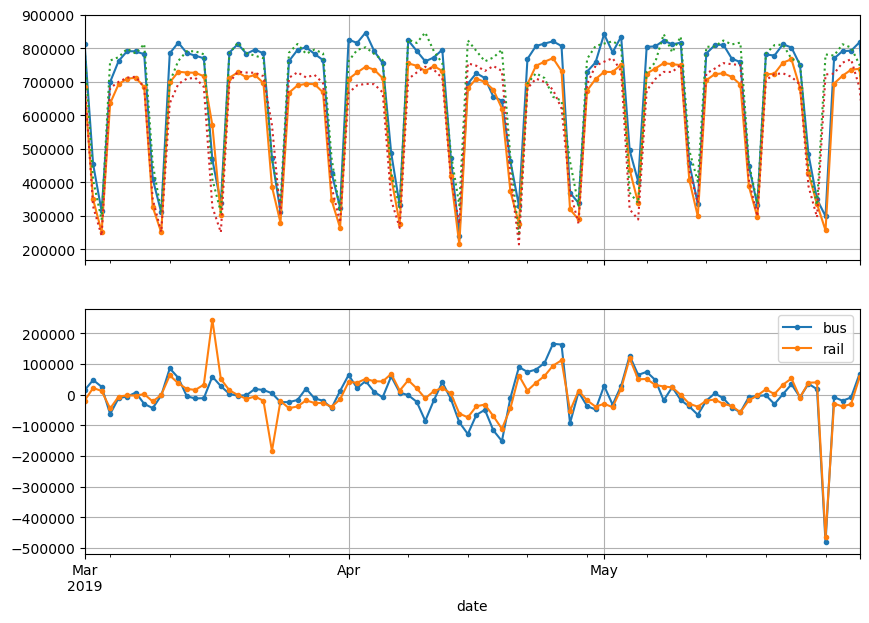

In [6]:
diff_7 = df[["bus", "rail"]].diff(7)["2019-03":"2019-05"]

fig, axs = plt.subplots(2, 1, sharex=True, figsize=(10, 7))
df.plot(ax=axs[0], legend=False, marker=".")  # original time series
df.shift(7).plot(ax=axs[0], grid=True, legend=False, linestyle=":")  # lagged
diff_7.plot(ax=axs[1], grid=True, marker=".")  # 7-day difference time series
axs[0].set_ylim([170_000, 900_000])  # extra code beautifies the plot
plt.show()

In [7]:
list(df.loc["2019-05-25":"2019-05-27"]["day_type"])

['A', 'U', 'U']

Mean absolute error (MAE), also called mean absolute deviation (MAD).

In [8]:
diff_7.abs().mean()

bus     43915.608696
rail    42143.271739
dtype: float64

Mean absolute percentage error (MAPE).

In [9]:
(diff_7 / df[["bus", "rail"]]).abs().mean()
# or we can do (diff_7 / df[["bus", "rail"]]["2019-03", "2109-05"]).abs().mean()

bus     0.082938
rail    0.089948
dtype: float64

Let's look at the yearly seasonality and the long-term trends:

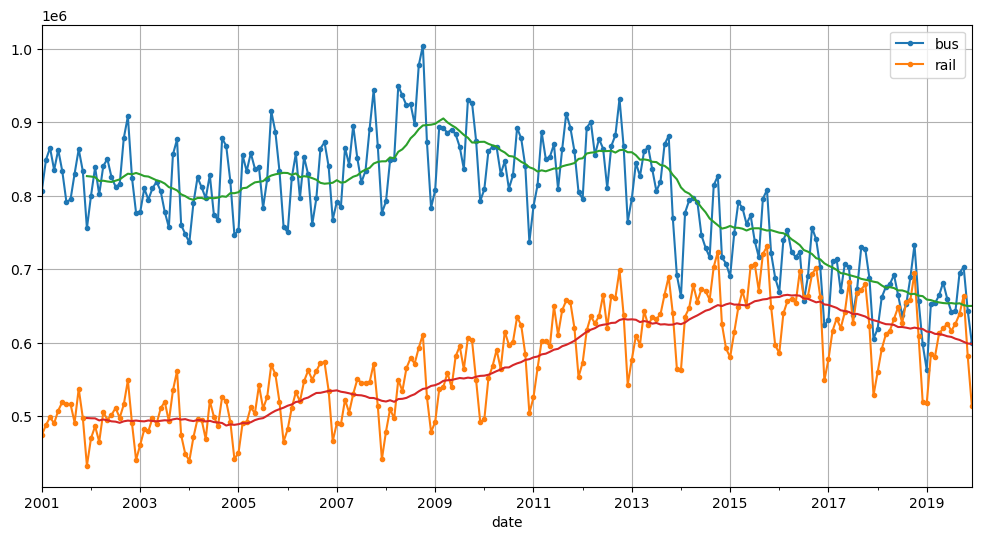

In [10]:
period = slice("2001", "2019")
df_monthly = df[["bus", "rail"]].resample("ME").mean()
rolling_average_12_months = df_monthly[period].rolling(window=12).mean()

fig, ax = plt.subplots(figsize=(12, 6))
df_monthly[period].plot(ax=ax, marker=".")
rolling_average_12_months.plot(ax=ax, grid=True, legend=False)
plt.show()

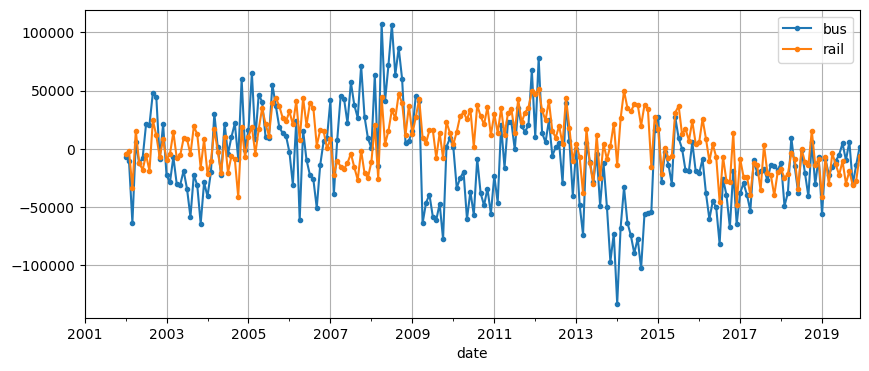

In [11]:
df_monthly.diff(12)[period].plot(grid=True, marker=".", figsize=(10, 4))
plt.show()

## The ARMA Model Family 

In [12]:
from statsmodels.tsa.arima.model import ARIMA

origin, today = "2019-01-01", "2019-05-31"
rail_series = df.loc[origin:today]["rail"].asfreq("D")
model = ARIMA(rail_series, order=(1, 0, 0), seasonal_order=(0, 1, 1, 7))
model = model.fit()
y_predict = model.forecast()

In [13]:
y_predict.iloc[0]  # ARIMA forecast

427758.626285891

In [14]:
df["rail"]["2019-06-01"]  # target value

379044

In [15]:
df["rail"]["2019-05-25"]  # naive forecast (value from one week earlier)

426932

In [16]:
(df["rail"]["2019-05-25"] / df["rail"]["2019-06-01"] - 1) * 100

12.633889469296445

In [17]:
origin, start_date, end_date = "2019-01-01", "2019-03-01", "2019-05-31"
time_period = pd.date_range(start_date, end_date)
rail_series = df.loc[origin:end_date]["rail"].asfreq("D")
y_predicts = []
for today in time_period.shift(-1):
    model = ARIMA(
        rail_series[origin:today],  # train on data up to "today"
        order=(1, 0, 0),
        seasonal_order=(0, 1, 1, 7),
    )
    model = model.fit()  # note that we retrain the model every day!
    y_predict = model.forecast().iloc[0]
    y_predicts.append(y_predict)

y_predicts = pd.Series(y_predicts, index=time_period)
mae = (y_predicts - rail_series[time_period]).abs().mean()

In [18]:
mae

32040.72011180737

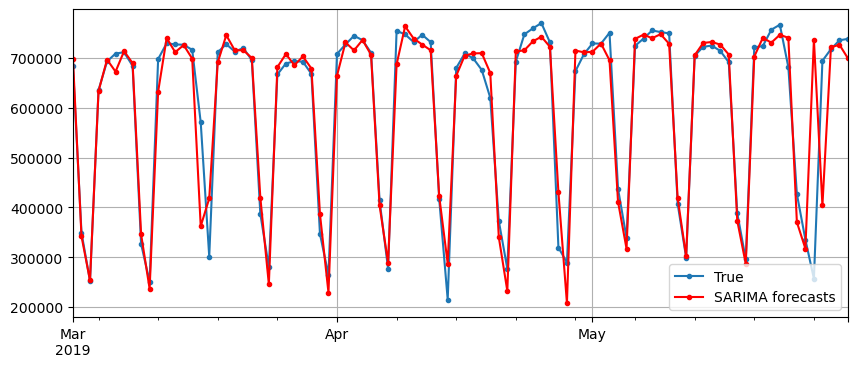

In [19]:
# extra code displays the SARIMA forecasts
fig, ax = plt.subplots(figsize=(10, 4))
rail_series.loc[time_period].plot(ax=ax, marker=".", grid=True, label=True)
ax.plot(y_predicts, color="r", marker=".", label="SARIMA forecasts")
plt.legend()
plt.show()

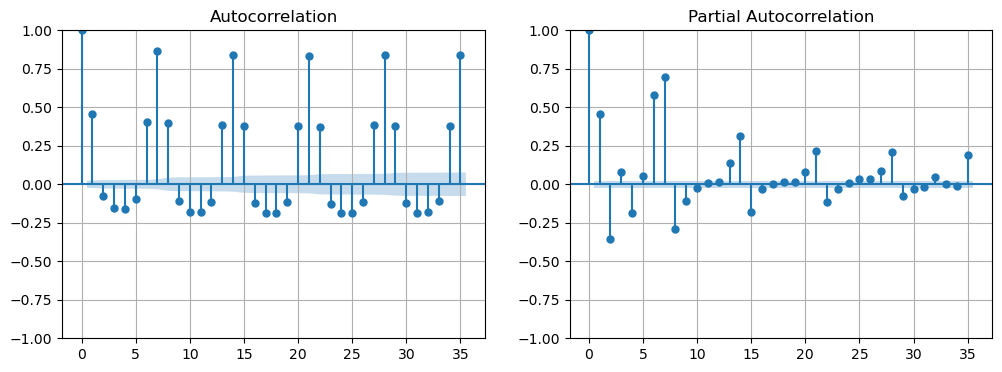

In [20]:
# Extra code shows how to plot the Autocorrelation Function (ACF) and the Partial Autocorrelation Function (PACF)

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axs = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(df[period]["rail"], ax=axs[0], lags=35)
axs[0].grid()
plot_pacf(df[period]["rail"], ax=axs[1], lags=35, method="ywm")
axs[1].grid()
plt.show()

## Preparing the Data for Machine Learning Models

In [21]:
my_series = [0, 1, 2, 3, 4, 5]
my_dataset = tf.keras.utils.timeseries_dataset_from_array(
    my_series, targets=my_series[3:], sequence_length=3, batch_size=2
)
list(my_dataset)

2024-03-24 12:47:41.111377: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2024-03-24 12:47:41.227534: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_28' with dtype int32 and shape [3]
	 [[{{node Placeholder/_28}}]]
2024-03-24 12:47:41.228069: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_28' with dtype int32 and shape [3]
	 [[{{node Placeholder/_28}}]]


[(<tf.Tensor: shape=(2, 3), dtype=int32, numpy=
  array([[0, 1, 2],
         [1, 2, 3]], dtype=int32)>,
  <tf.Tensor: shape=(2,), dtype=int32, numpy=array([3, 4], dtype=int32)>),
 (<tf.Tensor: shape=(1, 3), dtype=int32, numpy=array([[2, 3, 4]], dtype=int32)>,
  <tf.Tensor: shape=(1,), dtype=int32, numpy=array([5], dtype=int32)>)]

In [22]:
for window_dataset in tf.data.Dataset.range(6).window(4, shift=1):
    for element in window_dataset:
        print(f"{element}", end=" ")
    print()

0 1 2 3 
1 2 3 4 
2 3 4 5 
3 4 5 
4 5 
5 


2024-03-24 12:47:41.299800: W tensorflow/core/framework/dataset.cc:807] Input of Window will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2024-03-24 12:47:41.300051: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype variant
	 [[{{node Placeholder/_0}}]]
2024-03-24 12:47:41.304224: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype variant
	 [[{{node Placeholder/_0}}]]
2024-03-24 12:47:41.307052: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting 

In [23]:
datasets = tf.data.Dataset.range(6).window(4, shift=1, drop_remainder=True)
datasets = datasets.flat_map(lambda window_dataset: window_dataset.batch(4))
for window_tensor in datasets:
    print(f"{window_tensor}")

[0 1 2 3]
[1 2 3 4]
[2 3 4 5]


In [24]:
def to_window(dataset, length):
    dataset = dataset.window(length, shift=1, drop_remainder=True)
    return dataset.flat_map(lambda window_dataset: window_dataset.batch(length))

In [25]:
dataset = to_window(tf.data.Dataset.range(6), 4)
dataset = dataset.map(lambda window: (window[:-1], window[-1]))
list(dataset.batch(2))

[(<tf.Tensor: shape=(2, 3), dtype=int64, numpy=
  array([[0, 1, 2],
         [1, 2, 3]])>,
  <tf.Tensor: shape=(2,), dtype=int64, numpy=array([3, 4])>),
 (<tf.Tensor: shape=(1, 3), dtype=int64, numpy=array([[2, 3, 4]])>,
  <tf.Tensor: shape=(1,), dtype=int64, numpy=array([5])>)]

Before we continue looking at the data, let's split the time series into three periods: training, validation, and testing. We won't look at the test data for now.

In [26]:
rail_train = df["rail"]["2016-01":"2018-12"] / 1e6
rail_valid = df["rail"]["2019-01":"2019-05"] / 1e6
rail_test = df["rail"]["2019-06":] / 1e6

In [27]:
seq_length = 56
tf.random.set_seed(42)
train_ds = tf.keras.utils.timeseries_dataset_from_array(
    rail_train.to_numpy(),
    targets=rail_train[seq_length:],
    sequence_length=seq_length,
    batch_size=32,
    shuffle=True,
    seed=42,
)
valid_ds = tf.keras.utils.timeseries_dataset_from_array(
    rail_valid.to_numpy(),
    targets=rail_valid[seq_length:],
    sequence_length=seq_length,
    batch_size=32,
)

## Forecasting Using a Linear Model

In [28]:
tf.random.set_seed(42)
model = tf.keras.Sequential([tf.keras.layers.Dense(1, input_shape=[seq_length])])
early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    monitor="val_mae", patience=50, restore_best_weights=True
)
optimizer = tf.keras.optimizers.SGD(learning_rate=0.02, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics=["mae"])
history = model.fit(
    train_ds, validation_data=(valid_ds), epochs=500, callbacks=early_stopping_cb
)

Epoch 1/500


2024-03-24 12:47:41.620381: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_20' with dtype double and shape [1040]
	 [[{{node Placeholder/_20}}]]
2024-03-24 12:47:41.620691: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype int32 and shape [1040]
	 [[{{node Placeholder/_8}}]]


33/33 [==============================] - 0s 4ms/step - loss: 0.2414 - mae: 0.5543 - val_loss: 0.0177 - val_mae: 0.1476
Epoch 2/500
33/33 [==============================] - 0s 2ms/step - loss: 0.0160 - mae: 0.1412 - val_loss: 0.0124 - val_mae: 0.1291
Epoch 3/500


2024-03-24 12:47:41.913873: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [151]
	 [[{{node Placeholder/_0}}]]
2024-03-24 12:47:41.914153: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_20' with dtype double and shape [95]
	 [[{{node Placeholder/_20}}]]


33/33 [==============================] - 0s 2ms/step - loss: 0.0107 - mae: 0.1121 - val_loss: 0.0093 - val_mae: 0.1087
Epoch 4/500
33/33 [==============================] - 0s 2ms/step - loss: 0.0085 - mae: 0.0989 - val_loss: 0.0083 - val_mae: 0.1009
Epoch 5/500
33/33 [==============================] - 0s 3ms/step - loss: 0.0077 - mae: 0.0933 - val_loss: 0.0077 - val_mae: 0.0948
Epoch 6/500
33/33 [==============================] - 0s 2ms/step - loss: 0.0072 - mae: 0.0891 - val_loss: 0.0068 - val_mae: 0.0892
Epoch 7/500
33/33 [==============================] - 0s 2ms/step - loss: 0.0064 - mae: 0.0845 - val_loss: 0.0065 - val_mae: 0.0853
Epoch 8/500
33/33 [==============================] - 0s 2ms/step - loss: 0.0066 - mae: 0.0853 - val_loss: 0.0060 - val_mae: 0.0808
Epoch 9/500
33/33 [==============================] - 0s 3ms/step - loss: 0.0058 - mae: 0.0796 - val_loss: 0.0056 - val_mae: 0.0774
Epoch 10/500
33/33 [==============================] - 0s 2ms/step - loss: 0.0064 - mae: 0.0845 

In [29]:
# Extra code evaluates the model
valid_loss, valid_mae = model.evaluate(valid_ds)
valid_mae * 1e6

3/3 [==============================] - 0s 1ms/step - loss: 0.0023 - mae: 0.0380


38045.4882979393

## Forecasting Using a Simple RNN

In [30]:
tf.random.set_seed(42)
model = tf.keras.Sequential([tf.keras.layers.SimpleRNN(1, input_shape=[None, 1])])

In [31]:
def fit_and_evaluate(model, train_set, valid_set, learning_rate, epochs=500):
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(
        monitor="val_mae", patience=50, restore_best_weights=True
    )
    optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
    model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics=["mae"])
    history = model.fit(
        train_set,
        validation_data=valid_set,
        epochs=epochs,
        callbacks=[early_stopping_cb],
    )
    valid_loss, valid_mae = model.evaluate(valid_set)
    return valid_mae * 1e6

In [32]:
fit_and_evaluate(model, train_ds, valid_ds, learning_rate=0.02)

Epoch 1/500


33/33 [==============================] - 1s 8ms/step - loss: 0.0251 - mae: 0.1869 - val_loss: 0.0121 - val_mae: 0.1146
Epoch 2/500
33/33 [==============================] - 0s 5ms/step - loss: 0.0118 - mae: 0.1167 - val_loss: 0.0122 - val_mae: 0.1129
Epoch 3/500
33/33 [==============================] - 0s 5ms/step - loss: 0.0117 - mae: 0.1176 - val_loss: 0.0119 - val_mae: 0.1129
Epoch 4/500
33/33 [==============================] - 0s 5ms/step - loss: 0.0115 - mae: 0.1175 - val_loss: 0.0117 - val_mae: 0.1126
Epoch 5/500
33/33 [==============================] - 0s 5ms/step - loss: 0.0114 - mae: 0.1179 - val_loss: 0.0116 - val_mae: 0.1124
Epoch 6/500
33/33 [==============================] - 0s 5ms/step - loss: 0.0113 - mae: 0.1171 - val_loss: 0.0115 - val_mae: 0.1118
Epoch 7/500
33/33 [==============================] - 0s 6ms/step - loss: 0.0112 - mae: 0.1169 - val_loss: 0.0114 - val_mae: 0.1114
Epoch 8/500
33/33 [==============================] - 0s 5ms/step - loss: 0.0111 - mae: 0.1170 -

102769.53876018524

In [33]:
tf.random.set_seed(42)
univariate_model = tf.keras.Sequential(
    [tf.keras.layers.SimpleRNN(32, input_shape=[None, 1]), tf.keras.layers.Dense(1)]
)

In [34]:
fit_and_evaluate(univariate_model, train_ds, valid_ds, learning_rate=0.05)

Epoch 1/500


33/33 [==============================] - 1s 11ms/step - loss: 0.0219 - mae: 0.1511 - val_loss: 0.0036 - val_mae: 0.0644
Epoch 2/500
33/33 [==============================] - 0s 7ms/step - loss: 0.0043 - mae: 0.0667 - val_loss: 0.0026 - val_mae: 0.0474
Epoch 3/500
33/33 [==============================] - 0s 7ms/step - loss: 0.0040 - mae: 0.0623 - val_loss: 0.0028 - val_mae: 0.0483
Epoch 4/500
33/33 [==============================] - 0s 9ms/step - loss: 0.0033 - mae: 0.0529 - val_loss: 0.0020 - val_mae: 0.0330
Epoch 5/500
33/33 [==============================] - 0s 8ms/step - loss: 0.0034 - mae: 0.0537 - val_loss: 0.0036 - val_mae: 0.0637
Epoch 6/500
33/33 [==============================] - 0s 7ms/step - loss: 0.0034 - mae: 0.0552 - val_loss: 0.0028 - val_mae: 0.0496
Epoch 7/500
33/33 [==============================] - 0s 7ms/step - loss: 0.0030 - mae: 0.0489 - val_loss: 0.0024 - val_mae: 0.0383
Epoch 8/500
33/33 [==============================] - 0s 8ms/step - loss: 0.0035 - mae: 0.0562 

30403.59728038311

## Multivariate Time Series  

In [35]:
df_multivariate = df[["bus", "rail"]] / 1e6  # use both bus and rail series as input
df_multivariate["next_day_type"] = df["day_type"].shift(-1)  # we know tomorrow's type
df_multivariate = pd.get_dummies(df_multivariate, dtype=np.float32)

In [36]:
multivariate_train = df_multivariate["2016-01":"2018-12"]
multivariate_valid = df_multivariate["2019-01":"2019-05"]
multivariate_test = df_multivariate["2019-06":]

In [37]:
tf.random.set_seed(42)
seq_length = 56

train_multivariate_ds = tf.keras.utils.timeseries_dataset_from_array(
    multivariate_train.to_numpy(),  # use all 5 columns as input
    targets=multivariate_train["rail"][seq_length:],  # forecast only the rail series
    sequence_length=seq_length,
    shuffle=True,
    batch_size=32,
    seed=42,
)
valid_multivariate_ds = tf.keras.utils.timeseries_dataset_from_array(
    multivariate_valid.to_numpy(),
    targets=multivariate_valid["rail"][seq_length:],
    sequence_length=seq_length,
    batch_size=32,
)

In [38]:
multivariate_model = tf.keras.Sequential(
    [tf.keras.layers.SimpleRNN(32, input_shape=[None, 5]), tf.keras.layers.Dense(1)]
)

In [39]:
fit_and_evaluate(
    multivariate_model, train_multivariate_ds, valid_multivariate_ds, learning_rate=0.05
)

Epoch 1/500


2024-03-24 12:49:03.456543: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_20' with dtype double and shape [1040]
	 [[{{node Placeholder/_20}}]]
2024-03-24 12:49:03.456832: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [1096,5]
	 [[{{node Placeholder/_0}}]]


33/33 [==============================] - 1s 11ms/step - loss: 0.0294 - mae: 0.1821 - val_loss: 0.0014 - val_mae: 0.0390
Epoch 2/500


2024-03-24 12:49:04.191591: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype int32 and shape [95]
	 [[{{node Placeholder/_8}}]]
2024-03-24 12:49:04.191912: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_20' with dtype double and shape [95]
	 [[{{node Placeholder/_20}}]]


33/33 [==============================] - 0s 9ms/step - loss: 0.0025 - mae: 0.0537 - val_loss: 9.9688e-04 - val_mae: 0.0323
Epoch 3/500
33/33 [==============================] - 0s 7ms/step - loss: 0.0015 - mae: 0.0379 - val_loss: 9.0994e-04 - val_mae: 0.0323
Epoch 4/500
33/33 [==============================] - 0s 7ms/step - loss: 0.0014 - mae: 0.0374 - val_loss: 0.0012 - val_mae: 0.0387
Epoch 5/500
33/33 [==============================] - 0s 8ms/step - loss: 0.0014 - mae: 0.0360 - val_loss: 0.0010 - val_mae: 0.0362
Epoch 6/500
33/33 [==============================] - 0s 8ms/step - loss: 0.0015 - mae: 0.0395 - val_loss: 0.0011 - val_mae: 0.0369
Epoch 7/500
33/33 [==============================] - 0s 7ms/step - loss: 0.0013 - mae: 0.0358 - val_loss: 6.9321e-04 - val_mae: 0.0259
Epoch 8/500
33/33 [==============================] - 0s 8ms/step - loss: 0.0013 - mae: 0.0353 - val_loss: 0.0011 - val_mae: 0.0380
Epoch 9/500
33/33 [==============================] - 0s 8ms/step - loss: 0.0012 - m

22616.82227253914

In [40]:
# Extra code builds and trains a multitask RNN that forecasts both bus and rail

tf.random.set_seed(42)
train_multitask_ds = tf.keras.utils.timeseries_dataset_from_array(
    multivariate_train.to_numpy(),
    targets=multivariate_train[["bus", "rail"]][seq_length:],
    batch_size=32,
    shuffle=True,
    seed=42,
    sequence_length=seq_length,
)
valid_multitask_ds = tf.keras.utils.timeseries_dataset_from_array(
    multivariate_valid.to_numpy(),
    targets=multivariate_valid[["bus", "rail"]][seq_length:],
    batch_size=32,
    sequence_length=seq_length,
)

tf.random.set_seed(42)

multitask_model = tf.keras.Sequential(
    [tf.keras.layers.SimpleRNN(32, input_shape=[None, 5]), tf.keras.layers.Dense(2)]
)

fit_and_evaluate(
    multitask_model, train_multitask_ds, valid_multitask_ds, learning_rate=0.02
)

Epoch 1/500


2024-03-24 12:49:34.020802: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype int32 and shape [1040]
	 [[{{node Placeholder/_8}}]]
2024-03-24 12:49:34.021120: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_28' with dtype int32 and shape [1040]
	 [[{{node Placeholder/_28}}]]


33/33 [==============================] - 1s 9ms/step - loss: 0.0201 - mae: 0.1433 - val_loss: 0.0036 - val_mae: 0.0631
Epoch 2/500
 1/33 [..............................] - ETA: 1s - loss: 0.0050 - mae: 0.0765

2024-03-24 12:49:34.661734: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_28' with dtype int32 and shape [95]
	 [[{{node Placeholder/_28}}]]
2024-03-24 12:49:34.662214: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [151,5]
	 [[{{node Placeholder/_0}}]]


33/33 [==============================] - 0s 6ms/step - loss: 0.0031 - mae: 0.0585 - val_loss: 0.0017 - val_mae: 0.0430
Epoch 3/500
33/33 [==============================] - 0s 6ms/step - loss: 0.0023 - mae: 0.0476 - val_loss: 9.8667e-04 - val_mae: 0.0334
Epoch 4/500
33/33 [==============================] - 0s 6ms/step - loss: 0.0020 - mae: 0.0444 - val_loss: 0.0015 - val_mae: 0.0430
Epoch 5/500
33/33 [==============================] - 0s 8ms/step - loss: 0.0018 - mae: 0.0430 - val_loss: 8.1547e-04 - val_mae: 0.0286
Epoch 6/500
33/33 [==============================] - 0s 6ms/step - loss: 0.0017 - mae: 0.0415 - val_loss: 0.0010 - val_mae: 0.0335
Epoch 7/500
33/33 [==============================] - 0s 6ms/step - loss: 0.0017 - mae: 0.0414 - val_loss: 7.8288e-04 - val_mae: 0.0283
Epoch 8/500
33/33 [==============================] - 0s 7ms/step - loss: 0.0016 - mae: 0.0403 - val_loss: 0.0010 - val_mae: 0.0342
Epoch 9/500
33/33 [==============================] - 0s 8ms/step - loss: 0.0016 - m

27067.862451076508

In [41]:
# Extra code evaluates the naive forecasts for bus
bus_naive = multivariate_valid["bus"].shift(7)[seq_length:]
bus_target = multivariate_valid["bus"][seq_length:]
(bus_naive - bus_target).abs().mean() * 1e6

43441.63157894738

In [42]:
y_predict = multitask_model.predict(valid_multitask_ds)
for idx, name in enumerate(["bus", "rail"]):
    mae = 1e6 * tf.keras.losses.mean_absolute_error(
        multivariate_valid[name][seq_length:], y_predict[:, idx]
    )
    print(name, int(mae))

3/3 [==============================] - 0s 3ms/step
bus 26219
rail 27916


## Forecasting Several Steps Ahead

This is the code demonstrates the first option.

In [43]:
import numpy as np

X = rail_valid.to_numpy()[np.newaxis, :seq_length, np.newaxis]
for step_ahead in range(14):
    y_predict_one = univariate_model.predict(X)
    X = np.concatenate([X, y_predict_one.reshape(1, -1, 1)], axis=1)

1/1 [==============================] - 0s 14ms/step


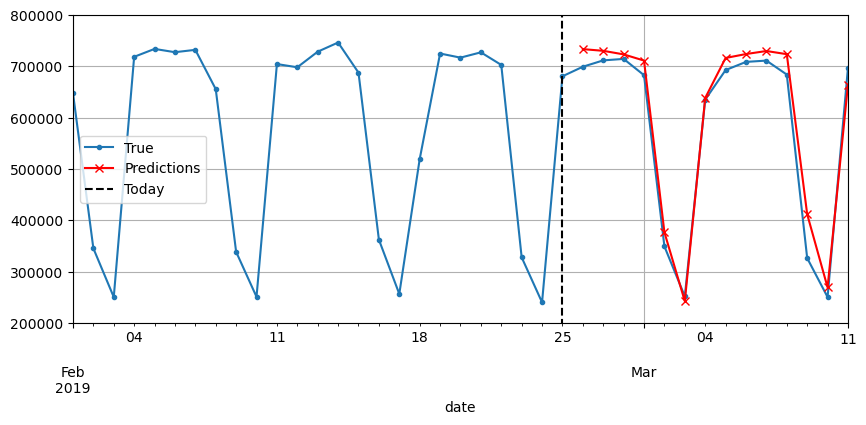

In [44]:
# Extra code generates and saves Figure 15-11 in the book

y_predict = pd.Series(X[0, -14:, 0], index=pd.date_range("2019-02-26", "2019-03-11"))

fig, ax = plt.subplots(figsize=(10, 4))
(rail_valid * 1e6)["2019-02-01":"2019-03-11"].plot(label="True", marker=".", ax=ax)
(y_predict * 1e6).plot(label="Predictions", grid=True, marker="x", color="r", ax=ax)
ax.vlines("2019-02-25", 0, 1e6, color="k", linestyle="--", label="Today")
plt.legend()
ax.set_ylim([200_000, 800_000])
plt.show()

Now, we create an RNN that predicts all 14 next values at once.

In [45]:
tf.random.set_seed(42)


def split_inputs_and_targets(multivariate_series, ahead=14, target_col=1):
    return multivariate_series[:, :-ahead], multivariate_series[:, -ahead:, target_col]


ahead_train_ds = tf.keras.utils.timeseries_dataset_from_array(
    multivariate_train.to_numpy(),
    targets=None,
    sequence_length=seq_length + 14,
    batch_size=32,
    shuffle=True,
    seed=42,
).map(split_inputs_and_targets)
ahead_valid_ds = tf.keras.utils.timeseries_dataset_from_array(
    multivariate_valid.to_numpy(),
    targets=None,
    batch_size=32,
    sequence_length=seq_length + 14,
).map(split_inputs_and_targets)

In [46]:
tf.random.set_seed(42)

ahead_model = tf.keras.Sequential(
    [tf.keras.layers.SimpleRNN(32, input_shape=[None, 5]), tf.keras.layers.Dense(14)]
)

In [47]:
fit_and_evaluate(ahead_model, ahead_train_ds, ahead_valid_ds, learning_rate=0.02)

Epoch 1/500


2024-03-24 12:51:25.911672: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_14' with dtype int32
	 [[{{node Placeholder/_14}}]]
2024-03-24 12:51:25.911932: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_14' with dtype int32
	 [[{{node Placeholder/_14}}]]


33/33 [==============================] - 1s 11ms/step - loss: 0.1126 - mae: 0.3522 - val_loss: 0.0274 - val_mae: 0.1845
Epoch 2/500
 1/33 [..............................] - ETA: 0s - loss: 0.0278 - mae: 0.1915

2024-03-24 12:51:26.633951: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [151,5]
	 [[{{node Placeholder/_0}}]]
2024-03-24 12:51:26.634331: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_14' with dtype int32
	 [[{{node Placeholder/_14}}]]


33/33 [==============================] - 0s 6ms/step - loss: 0.0209 - mae: 0.1656 - val_loss: 0.0160 - val_mae: 0.1372
Epoch 3/500
33/33 [==============================] - 0s 6ms/step - loss: 0.0153 - mae: 0.1412 - val_loss: 0.0124 - val_mae: 0.1230
Epoch 4/500
33/33 [==============================] - 0s 7ms/step - loss: 0.0128 - mae: 0.1285 - val_loss: 0.0106 - val_mae: 0.1122
Epoch 5/500
33/33 [==============================] - 0s 6ms/step - loss: 0.0113 - mae: 0.1201 - val_loss: 0.0094 - val_mae: 0.1045
Epoch 6/500
33/33 [==============================] - 0s 6ms/step - loss: 0.0102 - mae: 0.1120 - val_loss: 0.0081 - val_mae: 0.0991
Epoch 7/500
33/33 [==============================] - 0s 7ms/step - loss: 0.0093 - mae: 0.1069 - val_loss: 0.0073 - val_mae: 0.0926
Epoch 8/500
33/33 [==============================] - 0s 6ms/step - loss: 0.0086 - mae: 0.1015 - val_loss: 0.0066 - val_mae: 0.0876
Epoch 9/500
33/33 [==============================] - 0s 6ms/step - loss: 0.0080 - mae: 0.0968 -

35684.630274772644

In [53]:
# Here is how to make a prediction using this model
X = multivariate_valid.to_numpy()[np.newaxis, :seq_length]  # shape [1, 56, 5]
y_predict = ahead_model.predict(X)  # shape [1, 14]
y_predict

1/1 [==============================] - 0s 29ms/step


array([[0.73284876, 0.71786714, 0.75169647, 0.67918396, 0.3817452 ,
        0.25474688, 0.6381781 , 0.696158  , 0.74156296, 0.6994911 ,
        0.6585958 , 0.3932094 , 0.3211429 , 0.66359264]], dtype=float32)